In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import pickle
import glob
import itertools
import tqdm

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#Access The HandData
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/JEC/Colab/HandData/

/content/gdrive/MyDrive/JEC/Colab/HandData


In [ ]:
im_shape = 128  # 368
split = 0.7
batch_size = 64
epochs = 400

In [ ]:
base_path, files, folders = 'organized/data_', [], [2, 3, 4, 5, 6, 7, 8, 10] #Can't Get 9 Yet, Using 10 Instead
for i in range(len(folders)): files.append(glob.glob(''.join([base_path, str(folders[i]), '/1/*.jpg'])))
files_list = list(itertools.chain.from_iterable(files))

X = np.zeros((len(files_list), im_shape, im_shape, 3))
for n in tqdm.tqdm(range(len(files_list))):
  X[n] = cv2.resize(cv2.imread(files_list[n]), (im_shape, im_shape))/255

100%|██████████| 8250/8250 [26:08<00:00,  5.26it/s]


In [ ]:
print(files_list)
files_list[1]

['organized/data_2/1/1586_.jpg', 'organized/data_2/1/1587_.jpg', 'organized/data_2/1/1588_.jpg', 'organized/data_2/1/1589_.jpg', 'organized/data_2/1/0158_.jpg', 'organized/data_2/1/1590_.jpg', 'organized/data_2/1/1591_.jpg', 'organized/data_2/1/1592_.jpg', 'organized/data_2/1/1593_.jpg', 'organized/data_2/1/1594_.jpg', 'organized/data_2/1/1595_.jpg', 'organized/data_2/1/1596_.jpg', 'organized/data_2/1/1597_.jpg', 'organized/data_2/1/1598_.jpg', 'organized/data_2/1/1599_.jpg', 'organized/data_2/1/0159_.jpg', 'organized/data_2/1/0015_.jpg', 'organized/data_2/1/1600_.jpg', 'organized/data_2/1/1601_.jpg', 'organized/data_2/1/1602_.jpg', 'organized/data_2/1/1603_.jpg', 'organized/data_2/1/1604_.jpg', 'organized/data_2/1/1605_.jpg', 'organized/data_2/1/1606_.jpg', 'organized/data_2/1/1607_.jpg', 'organized/data_2/1/1608_.jpg', 'organized/data_2/1/1609_.jpg', 'organized/data_2/1/0160_.jpg', 'organized/data_2/1/1610_.jpg', 'organized/data_2/1/1611_.jpg', 'organized/data_2/1/1612_.jpg', 'organi

'organized/data_2/1/1587_.jpg'

In [ ]:
all_pts = []
idx = 0
Y = np.zeros((len(files_list), 38))

for j in folders:
    with open(''.join(['organized/data_', str(j), '_1_bbox_origin.pkl']), 'rb') as file:
        data_bbox = np.array(pickle.load(file))
    with open(''.join(['organized/data_', str(j), '_1_hand_keypoints.pkl']), 'rb') as file:
        vals = np.array(pickle.load(file))

    points = np.zeros((len(vals), 38))

    for i in range(len(vals)):
        d = vals[i][0]
        points[i] = np.concatenate((d[1][2:], d[2][2:]))
    points = points/368

    for i in range(len(points)):
        Y[idx] = points[i]
        idx += 1


<ipython-input-5-af270a7cdc03>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vals = np.array(pickle.load(file))


In [ ]:
N = len(Y)
Ntr = int(split*N)

ii = np.random.permutation(N)
xtr = X[ii[:Ntr]]
xte = X[ii[Ntr:]]
ytr = Y[ii[:Ntr]]
yte = Y[ii[Ntr:]]

xtr.shape, ytr.shape
xte.shape, yte.shape


((2475, 128, 128, 3), (2475, 38))

In [ ]:
del Y, X, points, vals, files, files_list, base_path

In [ ]:
loss_type = 'RMSE'

model_test = tf.keras.applications.DenseNet121(include_top=False, input_shape=(im_shape,im_shape,3))
for layer in model_test.layers:
  layer.trainable = True

x = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='elu',strides=(2,2))(model_test.output)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(.8)(x)
# x = tf.keras.layers.Dense(2048, activation='elu')(x)
# x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Dense(1024, activation='elu')(x)
x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Dense(512, activation='elu')(x)
x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Dense(256, activation='elu')(x)
x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Dense(128, activation='elu')(x)
x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Dense(64, activation='elu')(x)
x = tf.keras.layers.Dropout(.5)(x)
predictions = tf.keras.layers.Dense(38, activation = 'linear')(x)

model_test=tf.keras.Model(inputs=model_test.input,outputs=predictions)

if loss_type == 'huber':
  loss = tf.keras.losses.Huber()
elif loss_type == 'RMSE':
  loss = tf.keras.losses.MeanSquaredError()
elif loss_type == 'MAE':
  loss = tf.keras.losses.MeanAbsoluteError()

model_test.compile(
    optimizer=tf.keras.optimizers.SGD(0.00035),
    loss=loss,
    metrics=[tf.keras.losses.MeanSquaredError(),tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.Huber()],
    #run_eagerly=True,
    )

#tf.data.experimental.enable_debug_mode()

h = model_test.fit(
    xtr, ytr,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(xte, yte)
)

file_output = ''.join(['rpihand_', loss_type])

model_test.save(file_output+'rpi1k.h5')
model_test.save(file_output+'rpi1k.pkl')
#pickle.dump({'history':h},open(file_output+'.pkl', 'wb'))


Epoch 1/400
91/91 [==============================] - 902s 10s/step - loss: 1.3691 - mean_squared_error: 1.3669 - mean_absolute_error: 0.9237 - huber_loss: 0.5363 - val_loss: 0.2885 - val_mean_squared_error: 0.2885 - val_mean_absolute_error: 0.4396 - val_huber_loss: 0.1429
Epoch 2/400
91/91 [==============================] - 876s 10s/step - loss: 1.0383 - mean_squared_error: 1.0383 - mean_absolute_error: 0.8101 - huber_loss: 0.4358 - val_loss: 0.2550 - val_mean_squared_error: 0.2551 - val_mean_absolute_error: 0.4166 - val_huber_loss: 0.1269
Epoch 3/400
91/91 [==============================] - 865s 10s/step - loss: 0.9396 - mean_squared_error: 0.9397 - mean_absolute_error: 0.7707 - huber_loss: 0.4021 - val_loss: 0.2341 - val_mean_squared_error: 0.2342 - val_mean_absolute_error: 0.4009 - val_huber_loss: 0.1167
Epoch 4/400
87/91 [===========================>..] - ETA: 36s - loss: 0.8795 - mean_squared_error: 0.8795 - mean_absolute_error: 0.7459 - huber_loss: 0.3810

KeyboardInterrupt: ignored

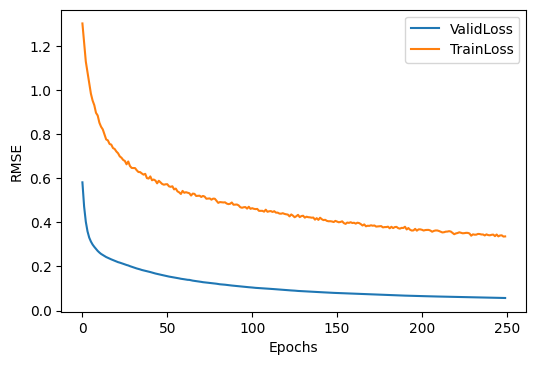

In [ ]:
graphVal = np.array(h.history['val_mean_squared_error'])
plt.figure(dpi=100)
plt.plot(graphVal, label="ValidLoss")
plt.plot(h.history['mean_squared_error'], label='TrainLoss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')

with open(file_output+'graph.npy', 'wb') as file:
  np.save(file, graphVal)
#pickle.dump({graphVal},open(file_output+'graph.pkl', 'wb'))

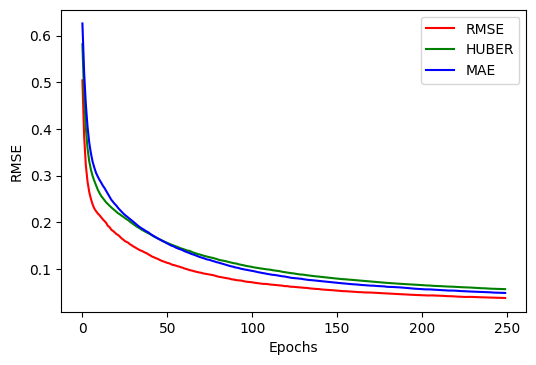

In [ ]:
# plt.figure(dpi=100)
# plt.plot(RMSE.history['val_mean_squared_error'], label='ValidLoss')
# plt.plot(RMSE.history['mean_squared_error'], label='TrainLoss')
# plt.legend()
# plt.xlabel('Epochs')
# plt.ylabel('RMSE')
# plt.savefig('densenet121_tr_te_loss.pdf')

#plt.figure(dpi=100)
#plt.plot(MAE.history['val_mean_absolute_error'], label='ValidLoss')
#plt.plot(MAE.history['mean_absolute_error'], label='TrainLoss')
# plt.plot(MAE.history['val_mean_squared_error'], label='ValidLoss')
# plt.plot(MAE.history['mean_squared_error'], label='TrainLoss')
# plt.legend()
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.savefig('densenet121_tr_te_loss2.pdf')

#plt.figure(dpi=100)
#plt.plot(Huber.history['val_huber_loss'], label='ValidLoss')
#plt.plot(Huber.history['huber_loss'], label='TrainLoss')
# plt.plot(Huber.history['val_mean_squared_error'], label='ValidLoss')
# plt.plot(Huber.history['mean_squared_error'], label='TrainLoss')
# plt.legend()
# plt.xlabel('Epochs')
# plt.ylabel('Huber')
# plt.savefig('densenet121_tr_te_loss3.pdf')
# RMSEpath = '/content/gdrive/MyDrive/JEC/Colab/HandData/rpihand_RMSE.pkl'
# Huberpath = '/content/gdrive/MyDrive/JEC/Colab/HandData/rpihand_huber.pkl'
# MAEpath = '/content/gdrive/MyDrive/JEC/Colab/HandData/rpihand_MAE.pkl'
# with open(RMSEpath, 'rb') as file:
#   RMSE = pickle.load(file,encoding="latin-1")
# with open(Huberpath, 'rb') as file:
#   Huber = pickle.load(file)
# with open(MAEpath, 'rb') as file:
#   MAE = pickle.load(file)

# plt.figure(dpi=100)
# plt.plot(RMSE.history['val_mean_squared_error'], label='ValidLoss',c='r')
# plt.plot(Huber.history['val_mean_squared_error'], label='ValidLoss',c='g')
# plt.plot(MAE.history['val_mean_squared_error'], label='ValidLoss',c='b')
# plt.legend()
# plt.xlabel('Epochs')
# plt.ylabel('RMSE')
# plt.savefig('TripleLossComparison.pdf')

RMSEpath = '/content/gdrive/MyDrive/JEC/Colab/HandData/rpihand_RMSEgraph.npy'
Huberpath = '/content/gdrive/MyDrive/JEC/Colab/HandData/rpihand_hubergraph.npy'
MAEpath = '/content/gdrive/MyDrive/JEC/Colab/HandData/rpihand_MAEgraph.npy'

with open(RMSEpath, 'rb') as file:
  RMSE = np.load(file)
with open(Huberpath, 'rb') as file:
  Huber = np.load(file)
with open(MAEpath, 'rb') as file:
  MAE = np.load(file)

plt.figure(dpi=100)
plt.plot(RMSE, label='RMSE',c='r')
plt.plot(Huber, label='HUBER',c='g')
plt.plot(MAE, label='MAE',c='b')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.savefig('TripleLossComparison.pdf')

25/25 [==============================] - 4s 34ms/step


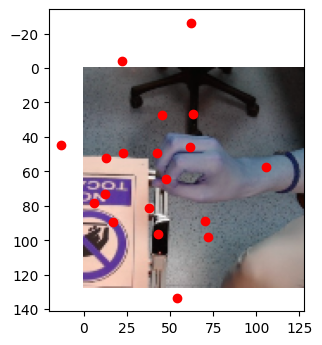

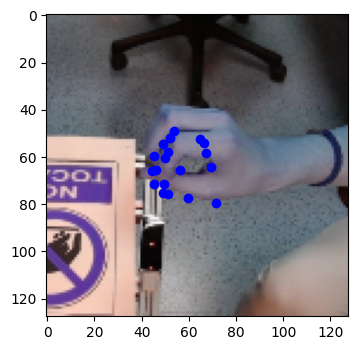

In [ ]:
#HUBER
i = 0
yhat = model_test.predict(xte)
yhat = yhat[i]*128
yt = yte[i]*128
plt.figure(dpi=100)
plt.imshow(xte[i])
plt.scatter(yhat[:19], yhat[19:], c='r')

plt.figure(dpi=100)
plt.imshow(xte[i])
plt.scatter(yt[:19], yt[19:], c='b')


25/25 [==============================] - 4s 33ms/step


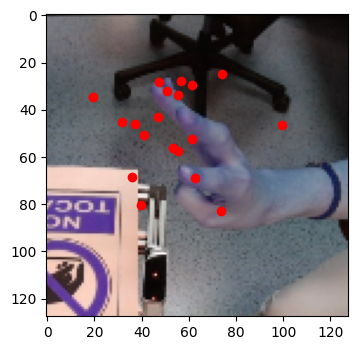

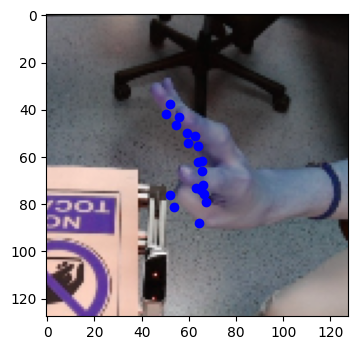

In [ ]:
#RMSE
i = 0
yhat = model_test.predict(xte)
yhat = yhat[i]*128
yt = yte[i]*128
plt.figure(dpi=100)
plt.imshow(xte[i])
plt.scatter(yhat[:19], yhat[19:], c='r')

plt.figure(dpi=100)
plt.imshow(xte[i])
plt.scatter(yt[:19], yt[19:], c='b')

25/25 [==============================] - 3s 32ms/step


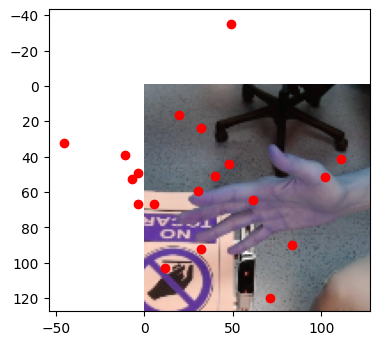

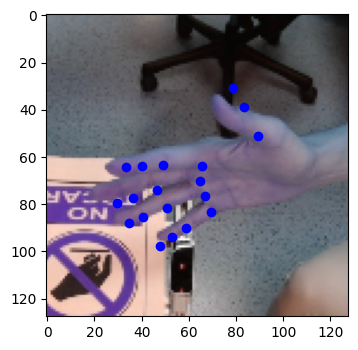

In [ ]:
#MAE
i = 0
yhat = model_test.predict(xte)
yhat = yhat[i]*128
yt = yte[i]*128
plt.figure(dpi=100)
plt.imshow(xte[i])
plt.scatter(yhat[:19], yhat[19:], c='r')

plt.figure(dpi=100)
plt.imshow(xte[i])
plt.scatter(yt[:19], yt[19:], c='b')

# **BELOW IS TUNING**

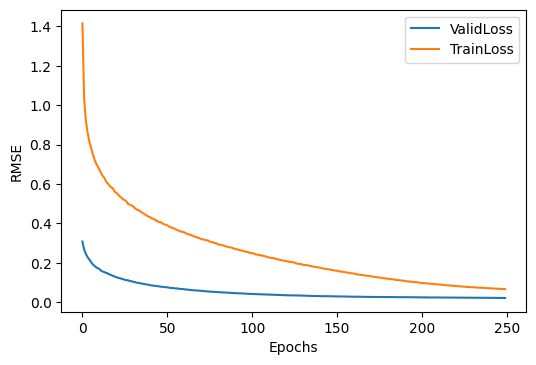

In [ ]:
plt.figure(dpi=100)
plt.plot(h.history['val_mean_squared_error'], label='ValidLoss')
plt.plot(h.history['mean_squared_error'], label='TrainLoss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.savefig('densenet121_tr_te_loss.pdf')

78/78 [==============================] - 6s 43ms/step


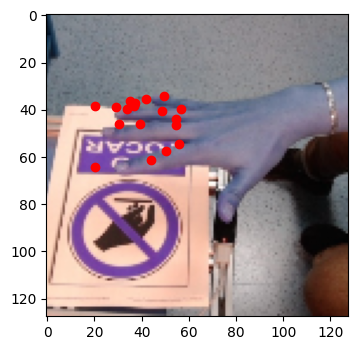

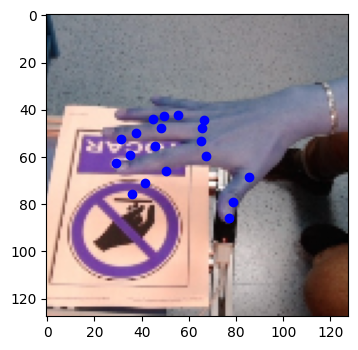

In [ ]:
i = 0
yhat = model_test.predict(xte)
yhat = yhat[i]*128
yt = yte[i]*128
plt.figure(dpi=100)
plt.imshow(xte[i])
plt.scatter(yhat[:19], yhat[19:], c='r')

plt.figure(dpi=100)
plt.imshow(xte[i])
plt.scatter(yt[:19], yt[19:], c='b')


In [ ]:
 model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', input_shape=(im_shape, im_shape, 3)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='elu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='elu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation='elu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=128, activation='elu'),
    tf.keras.layers.Dense(units=38, activation = 'softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(0.0001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError()],
    )

h = model.fit(
    xtr, ytr,
    batch_size=batch_size,
    epochs=100,
    validation_data=(xte, yte)
)

9/9 [==============================] - 1s 13ms/step


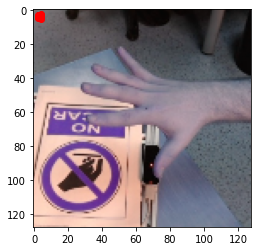

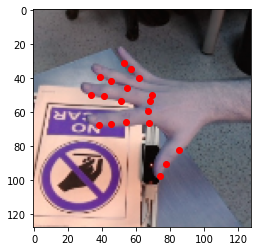

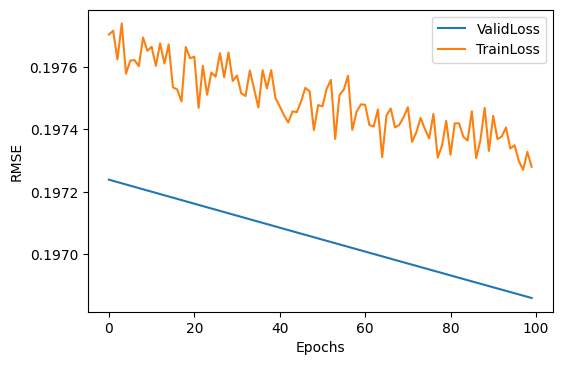

In [ ]:
i = 3
yhat = model.predict(xte)
yhat = yhat[i]*128
yt = yte[i]*128
plt.figure()
plt.imshow(xte[i])
plt.scatter(yhat[:19], yhat[19:], c='r')

plt.figure()
plt.imshow(xte[i])
plt.scatter(yt[:19], yt[19:], c='r')


plt.figure(dpi=100)
plt.plot(h.history['val_mean_squared_error'], label='ValidLoss')
plt.plot(h.history['mean_squared_error'], label='TrainLoss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.savefig('cnn_tr_te_loss.pdf')